## Setup

### Import Libraries, Set up device, Set up seeds

In [12]:
# Imports
import gpytorch
import torch
import numpy as np
import matplotlib.pyplot as plt
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.utils import standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
from tqdm import trange
import pandas as pd
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.models import ApproximateGP
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood, StudentTLikelihood
from gpytorch.mlls import VariationalELBO

# check for MPS and CUDA device availability
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS device found, setting as device.")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA device found, setting as device.")
else:
    device = torch.device("cpu")
    print("Neither MPS nor CUDA device found. Using default device (CPU).")


# set the seed for all random use
def set_seeds(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


set_seeds(1234)

# Initial setup
training_iterations = 50
num_initial_points = 10
num_new_samples_per_iteration = 1  # Change this to your desired number of new samples per iteration

CUDA device found, setting as device.


### Student-T Process Model

In [13]:
class STP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=False
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)

        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### Exact Gaussian Process Model

In [14]:
class ExactGP(gpytorch.models.ExactGP):
    def __init__(self, x_train, y_train, likelihood):
        # build the model using the ExactGP model from gpytorch
        super(ExactGP, self).__init__(x_train, y_train, likelihood)

        # use a constant mean, this value can be learned from the dataset
        self.mean_module = gpytorch.means.ConstantMean()

        # automatically determine the number of dimensions for the ARD kernel
        num_dimensions = x_train.shape[1]

        # use a scaled Matern kernel, the ScaleKernel allows the kernel to learn a scale factor for the dataset
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=2.5,ard_num_dims=num_dimensions))
            
        # set the number of outputs 
        self.num_outputs = 1

    def forward(self, x):
        # forward pass of the model

        # compute the mean and covariance of the model 
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)

        # return the MultivariateNormal distribution of the mean and covariance 
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    

### Variational Gaussian Process Model

In [15]:
class VariationalGP(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super(VariationalGP, self).__init__(variational_strategy)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel(ard_num_dims=inducing_points.size(1)))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### Standard Scalars

In [16]:
class TorchStandardScaler:
    def fit(self, x):
        x = x.clone()
        # calculate mean and std of the tensor
        self.mean = x.mean(0, keepdim=True)
        self.std = x.std(0, unbiased=False, keepdim=True)
    def transform(self, x):
        x = x.clone()
        # standardize the tensor
        x -= self.mean
        x /= (self.std + 1e-10)
        return x
    def fit_transform(self, x):
        # copy the tensor as to not modify the original 
        x = x.clone()
        # calculate mean and std of the tensor
        self.mean = x.mean(0, keepdim=True)
        self.std = x.std(0, unbiased=False, keepdim=True)
        # standardize the tensor
        x -= self.mean
        x /= (self.std + 1e-10)
        return x
    
class TorchNormalizer:
    def fit(self, x):
        # calculate the maximum value and the minimum value of the tensor
        self.max = torch.max(x, dim=0).values
        self.min = torch.min(x, dim=0).values

    def transform(self, x):
        # normalize the tensor
        return (x.clone() - self.min) / (self.max - self.min)

    def fit_transform(self, x):
        # calculate the maximum value and the minimum value of the tensor
        self.max = torch.max(x, dim=0).values
        self.min = torch.min(x, dim=0).values
        # normalize the tensor
        return (x.clone() - self.min) / (self.max - self.min)

### Acquisition Functions

In [17]:
# Upper Confidence Bound
def UCB(mean, std, beta):
    return mean + beta * std


# Expected Improvement
def EI(mean, std, best_observed):
    z = (mean - best_observed) / std
    return (mean - best_observed) * torch.distributions.Normal(0, 1).cdf(z) + std * torch.distributions.Normal(0, 1).log_prob(z)

### Randomly initialize training data with 10 points


In [18]:
dataset = 'Perovskite'
data = pd.read_csv(f"datasets/{dataset}_dataset.csv")

# merge rows that have the same output values
data = data.groupby(list(data.columns[:-1])).mean()
data = pd.DataFrame(data.reset_index())

# create tensors of the input and output data
train_x = torch.tensor(data.iloc[:, :-1].values)
train_y = torch.tensor(data.iloc[:, -1].values)

# We are using prededfined candidates, so we can scale at the start
TorchStd = TorchStandardScaler()
TorchStd.fit(train_x)

total_samples = len(train_y)

indicesSTP = torch.randperm(total_samples)[:num_initial_points]
indicesEGP = indicesSTP
indicesVGP = indicesSTP

train_xSTP = train_x[indicesSTP]
train_ySTP = train_y[indicesSTP]
train_xEGP = train_xSTP
train_yEGP = train_ySTP
train_xVGP = train_xSTP
train_yVGP = train_ySTP
initialPoints = train_xSTP
initialPointsy = train_ySTP

556


## Bayesian Optimization Loop

### Student-T Process Optimization

In [19]:
for _ in trange(training_iterations):
    # standardize the initial inputs and outputs before
    # torch_std = TorchStandardScaler()
    # train_xSTP = torch_std.fit_transform(train_xSTP)
    # y_scaler = TorchStandardScaler()
    # train_ySTP = y_scaler.fit_transform(train_ySTP).flatten()  # Ensure y is 1-dimensional

    #def train_and_test_approximate_gp(objective_function_cls):
    model = STP(train_xSTP).to(dtype=torch.float64)
    #likelihood = gpytorch.likelihoods.GaussianLikelihood()
    likelihood = gpytorch.likelihoods.StudentTLikelihood()
    objective_function = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_ySTP.numel())
    # replace with gpytorch mll
    optimizer = torch.optim.Adam(list(model.parameters()) + list(likelihood.parameters()), lr=0.1)

    

    # Train
    model.train()
    #put it into training mode
    likelihood.train()

    for _ in range(50):
        output = model(train_xSTP)
        loss = -objective_function(output, train_ySTP)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        


    # Test
    model.eval()
    likelihood.eval()

    # works wtih the variational distribution
    with gpytorch.settings.num_likelihood_samples(512):
        observed_pred = likelihood(model(train_x))

    samples = observed_pred.sample()


    # use as inputs to UCB 
    meanSTP = samples.mean(dim=0)
    stdSTP = samples.std(dim=0)
    

    # Select new points using UCB
    ucb_values = UCB(meanSTP, stdSTP, 1.96)
    ucb_values[indicesSTP] = float('inf')
    indicesSTP = torch.cat([indicesSTP, ucb_values.argmin().unsqueeze(0)])


    # Convert new_indices to a tensor
    # Add the new points to the training data
    train_xSTP = train_x[indicesSTP]
    train_ySTP = train_y[indicesSTP]

model.eval()
likelihood.eval()
    

100%|██████████| 50/50 [00:15<00:00,  3.14it/s]


StudentTLikelihood(
  (quadrature): GaussHermiteQuadrature1D()
  (raw_noise_constraint): Positive()
  (raw_deg_free_constraint): GreaterThan(2.000E+00)
)

### Exact Gaussian Process Optimization

In [20]:
for i in trange(training_iterations):
    # standardize the initial inputs and outputs before
    # torch_std = TorchStandardScaler()
    # train_xGP = torch_std.fit_transform(train_xGP)
    # y_scaler = TorchStandardScaler()
    # train_yGP = y_scaler.fit_transform(train_yGP).flatten()

    bestY_EGP = train_yEGP.min().item()

    # optimize the model
    # use a half normal prior for the noise to find a Gaussian likelihood
    likelihood = GaussianLikelihood(noise_prior=gpytorch.priors.HalfNormalPrior(0.01))

    # using the found likelihood, create a GP model
    gp = ExactGP(train_xEGP, train_yEGP, likelihood)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp)

    # fit the model by maximizing the marginal log likelihood
    gp.train()
    likelihood.train()
    fit_gpytorch_mll(mll)

    gp.eval()
    likelihood.eval()

    # predict from candidate pool
    with torch.no_grad():
        pred = gp(train_x) # predict values for all candidates

    meanEGP = pred.mean
    stdEGP = pred.stddev

    # pass the predictions through an acquisition function to find the next best point to sample
    acqVal = UCB(meanEGP, stdEGP, 1.96)
    acqVal[indicesEGP] = float('inf')  # Don't select already sampled points
    indicesEGP = torch.cat([indicesEGP, acqVal.argmin().unsqueeze(0)]) # add best value to index

    # add the new point to the training data
    train_xEGP = train_x[indicesEGP]
    train_yEGP = train_y[indicesEGP]

model.eval()
likelihood.eval()

  4%|▍         | 2/50 [00:00<00:10,  4.67it/s]c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
 12%|█▏        | 6/50 [00:00<00:07,  6.24it/s]c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
 34%|███▍      | 17/50 [00:03<00:05,  5.76it/s]c:\Users\stan\miniconda3\envs\researchTP\Lib\si

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (noise_prior): HalfNormalPrior()
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

### Variational Gaussian Process Optimization

In [21]:
for _ in trange(training_iterations):
    # standardize the initial inputs and outputs before
    # torch_std = TorchStandardScaler()
    # train_xSTP = torch_std.fit_transform(train_xSTP)
    # y_scaler = TorchStandardScaler()
    # train_ySTP = y_scaler.fit_transform(train_ySTP).flatten()  # Ensure y is 1-dimensional

    #def train_and_test_approximate_gp(objective_function_cls):
    model = VariationalGP(train_xVGP).to(dtype=torch.float64)

    likelihood = GaussianLikelihood()
    objective_function = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_yVGP.numel())
    # replace with gpytorch mll
    optimizer = torch.optim.Adam(list(model.parameters()) + list(likelihood.parameters()), lr=0.1)

    # Train
    model.train()
    #put it into training mode
    likelihood.train()

    for _ in range(50):
        output = model(train_xVGP)
        loss = -objective_function(output, train_yVGP)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    # Test
    model.eval()
    likelihood.eval()

    # works wtih the variational distribution
    with gpytorch.settings.num_likelihood_samples(512):
        observed_pred = likelihood(model(train_x))

    samples = observed_pred.sample(torch.Size((100,)))

    # get the mean and standard deviation of the samples
    meanVGP = samples.mean(dim=0)
    stdVGP = samples.std(dim=0)

    # Select new points using UCB
    ucb_values = UCB(meanVGP, stdVGP, 1.96)
    ucb_values[indicesVGP] = float('inf')
    indicesVGP = torch.cat([indicesVGP, ucb_values.argmin().unsqueeze(0)])


    # Convert new_indices to a tensor
    # Add the new points to the training data
    train_xVGP = train_x[indicesVGP]
    train_yVGP = train_y[indicesVGP]

model.eval()
likelihood.eval()
    

100%|██████████| 50/50 [00:09<00:00,  5.06it/s]


GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

## Visualization

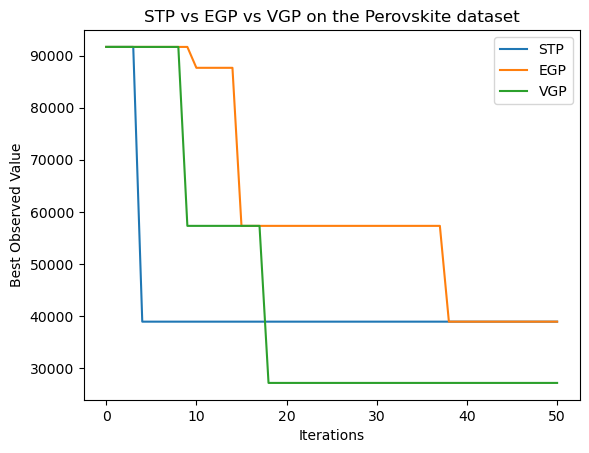

In [22]:
# create a list of iterations 
iterations = list(range(0, training_iterations + 1))

maxOutputSTP = []
maxOutputSTP.append(initialPointsy.min().item())
highestValueSTP = initialPointsy.min().item()


# convert the train_ySTP to a list
outputSTP = train_ySTP.tolist()

outputSTP = outputSTP[num_initial_points:]

for i in range(len(outputSTP)):
    if outputSTP[i] < highestValueSTP:
        highestValueSTP = outputSTP[i]
    maxOutputSTP.append(highestValueSTP)



maxOutputEGP = []
maxOutputEGP.append(initialPointsy.min().item())

# convert the train_ySTP to a list
outputEGP = train_yEGP.tolist()
highestValueEGP = initialPointsy.min().item()

outputEGP = outputEGP[num_initial_points:]

for i in range(len(outputEGP)):
    if outputEGP[i] < highestValueEGP:
        highestValueEGP = outputEGP[i]
    maxOutputEGP.append(highestValueEGP)


maxOutputVGP = []
maxOutputVGP.append(initialPointsy.min().item())

# convert the train_ySTP to a list
outputVGP = train_yVGP.tolist()
highestValueVGP = initialPointsy.min().item()

outputVGP = outputVGP[num_initial_points:]

for i in range(len(outputVGP)):
    if outputVGP[i] < highestValueVGP:
        highestValueVGP = outputVGP[i]
    maxOutputVGP.append(highestValueVGP)


plt.plot(iterations, maxOutputSTP, label='STP')
plt.plot(iterations, maxOutputEGP, label='EGP')
plt.plot(iterations, maxOutputVGP, label='VGP')
plt.xlabel('Iterations')
plt.ylabel('Best Observed Value')
plt.title('STP vs EGP vs VGP on the '+ dataset + ' dataset')
plt.legend()
